In [1]:
import numpy as np
import matplotlib.pyplot as plt 
plt.style.use('dark_background')
import seaborn as sns
import pandas as pd 
from scipy import stats
import graphviz as gr
from linearmodels.iv import IV2SLS
import statsmodels.api as sm
import statsmodels.formula.api as smf
from data_loader import load

In [2]:
email = load("invest_email_rnd.csv")
email.head()

,age,income,insurance,invested,em1,em2,em3,converted
0,44.1,5483.80,6155.29,14294.81,0,1,1,0
1,39.8,2737.92,50069.40,7468.15,1,0,0,0
2,49.0,2712.51,5707.08,5095.65,1,0,1,1
3,39.7,2326.37,15657.97,6345.20,1,1,1,0
4,35.3,2787.26,27074.44,14114.86,1,1,1,0


In [3]:
from sklearn.model_selection import train_test_split

np.random.seed(123)
train, test = train_test_split(email, test_size=0.4)
print(train.shape, test.shape)

(9000, 8) (6000, 8)


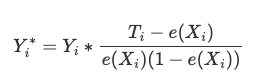

In [5]:
y = "converted"
T = "em1"
X = ["age", "income", "insurance", "invested"]

propensity_score = train[T].mean() # this is propesnity due to random assignment 

y_star_train = train[y] * (train[T] - propensity_score)/(propensity_score*(1-propensity_score))

In [9]:
from sklearn.ensemble import GradientBoostingRegressor

cate_learner = GradientBoostingRegressor(random_state=0)
cate_learner.fit(train[X], y_star_train)

GradientBoostingRegressor(random_state=0)

In [10]:
test_pred = test.assign(cate=cate_learner.predict(test[X]))
test_pred.head()

,age,income,insurance,invested,em1,em2,em3,converted,cate
6958,40.9,4486.14,37320.33,12559.25,0,0,1,0,0.097801
7534,42.6,6386.19,13270.47,29114.42,0,0,1,0,0.008640
2975,47.6,1900.26,25588.72,2420.39,0,0,1,0,0.021027
3903,41.0,5802.19,57087.37,20182.20,1,0,1,1,0.083353
8437,49.1,2202.96,5050.81,9245.88,1,0,1,0,0.033555


In [18]:
def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    ## add (rows/size) as a normalizer. 
    return np.array([sensitivity(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

def elast(data, y, t):
        return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
                np.sum((data[t] - data[t].mean())**2))
    
def sensitivity(data, y, t):
        # line coeficient for the one variable linear regression 
        return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
                np.sum((data[t] - data[t].mean())**2))

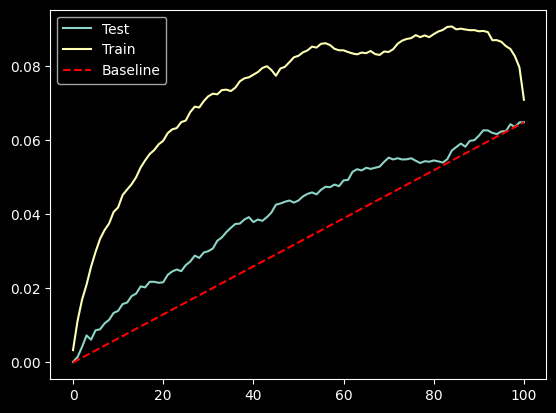

In [20]:
gain_curve_test = cumulative_gain(test_pred, "cate", y="converted", t="em1")
gain_curve_train = cumulative_gain(train.assign(cate=cate_learner.predict(train[X])), "cate", y="converted", t="em1")
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, "converted", "em1")], linestyle="--", color="red", label="Baseline")
plt.legend();

Target transformation like this can be used to predict heterogenous treatment effect. THe cost is high variance. This is all in the binary treatment case. 

# The continous treatment case 

In [21]:
prices_rnd = load("ice_cream_sales_rnd.csv")
prices_rnd.head()

,temp,weekday,cost,price,sales
0,25.8,1,0.3,7,230
1,22.7,3,0.5,4,190
2,33.7,7,1.0,5,237
3,23.0,4,0.5,5,193
4,24.4,1,1.0,3,252


In [22]:
np.random.seed(123)
train, test = train_test_split(prices_rnd, test_size=0.3)
train.shape, test.shape

((3500, 5), (1500, 5))

In [23]:
y_star_cont = (train["price"] - train["price"].mean()
               *train["sales"] - train["sales"].mean())

In [27]:
from sklearn.ensemble import GradientBoostingRegressor

cate_learner = GradientBoostingRegressor(random_state=0)
cate_learner.fit(train[["temp", "weekday", "cost"]], y_star_cont)
cate_test_transf_y = cate_learner.predict(test[["temp", "weekday", "cost"]])

test_pred = test.assign(cate=cate_test_transf_y)
test_pred.sample(5)

,temp,weekday,cost,price,sales,cate
603,17.0,7,0.3,9,211,-1578.230734
1040,21.5,3,1.0,5,193,-1449.191158
3810,17.7,7,0.3,9,201,-1639.333770
4829,21.4,5,0.5,9,188,-1415.946128
1971,28.8,4,0.3,6,201,-1522.980660


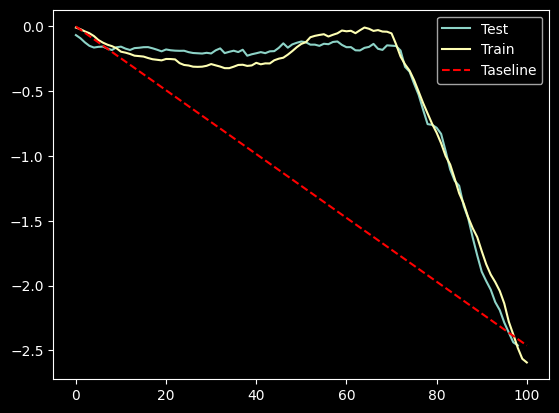

In [29]:
gain_curve_test = cumulative_gain(test.assign(cate=cate_test_transf_y),
                                "cate", y="sales", t="price")

gain_curve_train = cumulative_gain(train.assign(cate=cate_learner.predict(train[["temp", "weekday", "cost"]])),
                                   "cate", y="sales", t="price")


plt.plot(gain_curve_test, label="Test")
plt.plot(gain_curve_train, label="Train")
plt.plot([0, 100], [0, elast(test, "sales", "price")], linestyle="--", color="red", label="Taseline")
plt.legend();

- assumes linearity on treatment effect
- usually elasticity or treatment effect changes with the treatment itself. (nonlinear)
- *need to try linearize treatment effect with transformations*
    - logs, sqrt, inverse